<a href="https://colab.research.google.com/github/Kimiko00/Anomaly-Detection-on-sensors-data/blob/main/Anomali_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving tbl_datas_sismola.csv to tbl_datas_sismola.csv


In [ ]:
!nvidia-smi

Wed Mar 31 03:36:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 41kB/s 


In [ ]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import rc
from pylab import rcParams
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = pd.read_csv('tbl_datas_sismola.csv', sep=';')
# print(df.head())
df["insert_date"] = pd.to_datetime(df["insert_date"], format="%d-%m-%y %H:%M")
df.drop(['suhu2', 'kelembaban_tanah', 'ph', 'kelembaban_udara', 'curah_hujan'], inplace=True, axis=1)
# df = df[['intensitas_cahaya']]
# df = df.sort_values('insert_date')
df = df.set_index("insert_date")
print(df.head()), print(len(df))

                     intensitas_cahaya  suhu1
insert_date                                  
2019-08-02 15:05:00                 37  27.81
2019-08-02 15:10:00                 24  27.81
2019-08-02 15:55:00                 27  26.94
2019-08-02 16:00:00                  8  27.19
2019-08-02 16:05:00                 23  27.25
113930


(None, None)

[]

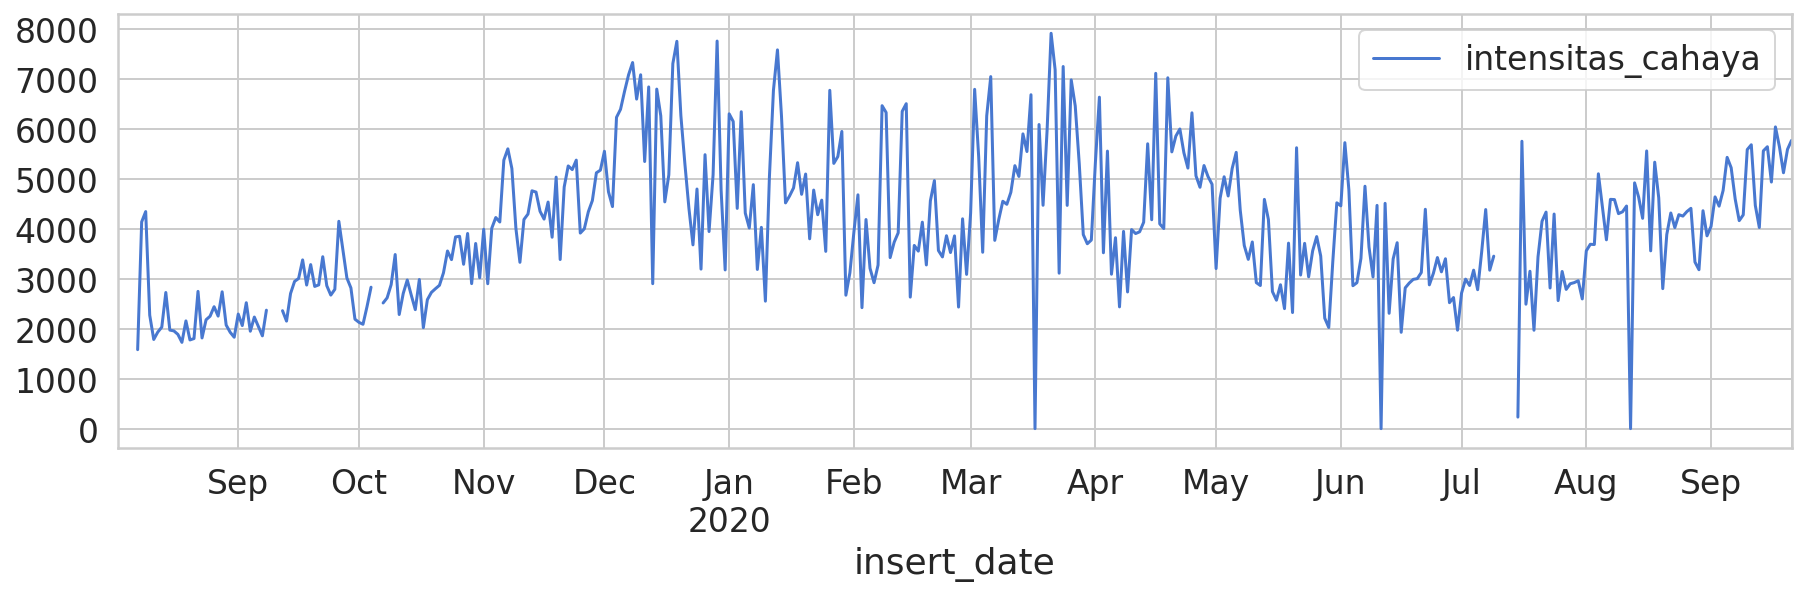

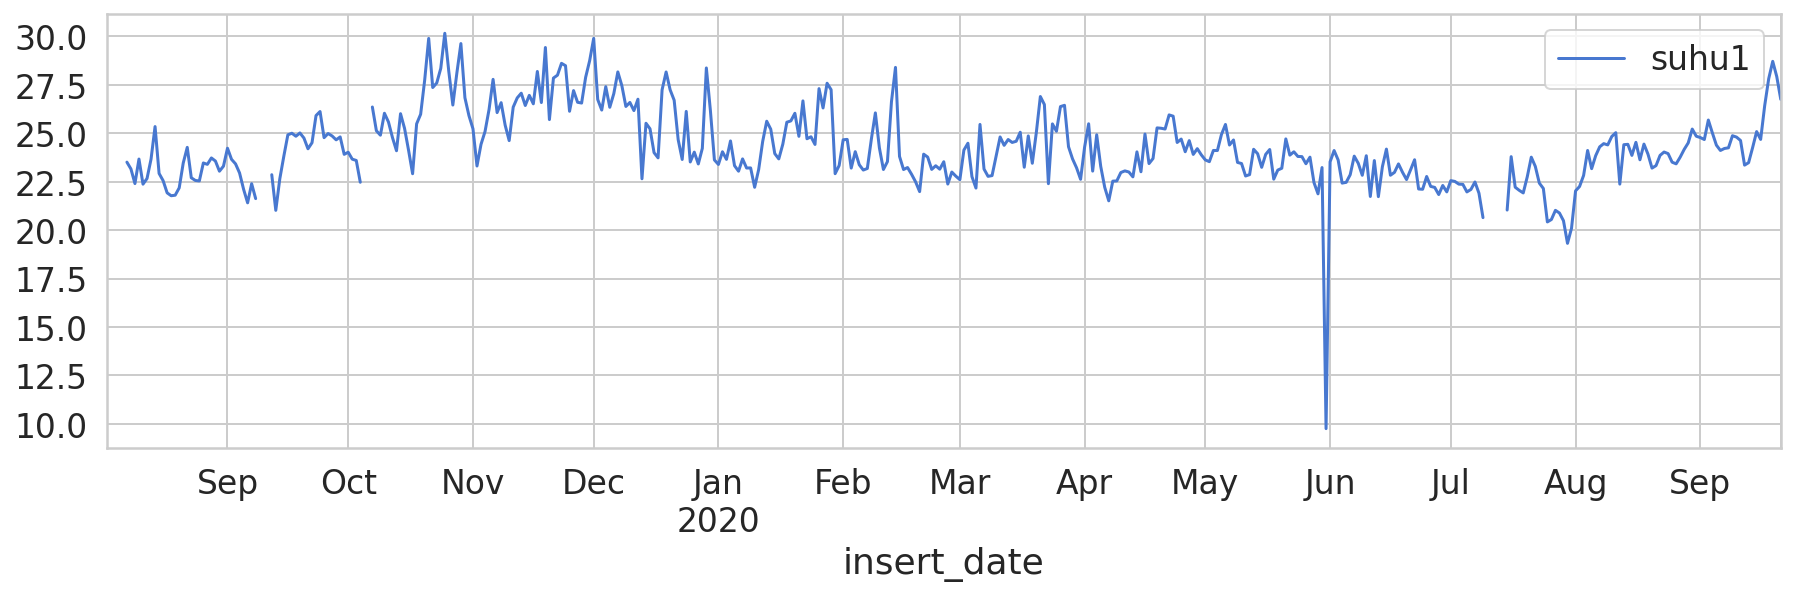

In [ ]:
tr = df[["intensitas_cahaya"]].resample("1d").mean().plot(figsize=(15,4))
tr = df[["suhu1"]].resample("1d").mean().plot(figsize=(15,4))
sns.set(rc={'figure.figsize':(20, 10)})
tr.plot(figsize=(15,4))

In [ ]:
# menghapus index duplicate dan menyimpan duplicate yang pertama
df_dup = df[~df.index.duplicated(keep='first')]
df_new = df_dup[['intensitas_cahaya']]

print(df_new)

                     intensitas_cahaya
insert_date                           
2019-08-02 15:05:00                 37
2019-08-02 15:10:00                 24
2019-08-02 15:55:00                 27
2019-08-02 16:00:00                  8
2019-08-02 16:05:00                 23
...                                ...
2020-09-21 22:50:00                  0
2020-09-21 22:55:00                  0
2020-09-21 23:00:00                  0
2020-09-21 23:05:00                  0
2020-09-21 23:10:00                  0

[112325 rows x 1 columns]


In [ ]:
print(f"start date: {df_new.index.min()} and the end date: {df_new.index.max()}")

start date: 2019-08-02 15:05:00 and the end date: 2020-09-21 23:10:00


In [ ]:
df_reindexed = df_new.reindex(pd.date_range(start=df_new.index.min(), end=df_new.index.max(), freq='5min'))
# You can try to interpolate it, if it shows linear behaviour in General.
# but Interpolation should only be done on limited sizes of windows e.g. 3 consecutive nans
# df_reindexed = df_reindexed.interpolate(method='time') 
print(df_reindexed), print((len(df_reindexed)))

                     intensitas_cahaya
2019-08-02 15:05:00               37.0
2019-08-02 15:10:00               24.0
2019-08-02 15:15:00                NaN
2019-08-02 15:20:00                NaN
2019-08-02 15:25:00                NaN
...                                ...
2020-09-21 22:50:00                0.0
2020-09-21 22:55:00                0.0
2020-09-21 23:00:00                0.0
2020-09-21 23:05:00                0.0
2020-09-21 23:10:00                0.0

[119906 rows x 1 columns]
119906


(None, None)

In [ ]:
# df_reindexed.to_csv (r'/content/drive/MyDrive/reindexing.csv', index=True, header=True)

In [ ]:
# checking nans value after reindexing
df_reindexed.isnull().sum()

intensitas_cahaya    7754
dtype: int64

In [ ]:
# MY_CLUE  CLEAR
# But for training the LSTM you need to have a series with zero nans
# don't drop nans because you need a follow-up of values for LSTM and thus the values and dates should be consistent without gaps
# It shouldn't just jump from 5 minutes to 15 minutes without the value for 10 minutes in between (gap values on the data)

# merge the data frame on a date range that includes all dates from start to end date
# df = pd.merge(pd.date_range(df["insert_date"].min(), df["insert_date"].max(), freq="5M"),df)
    
# def create_dataset():
# # This is to ensure that batches of data that include nans are skipped thus not used

#   if not df.isna().empty:
#     continue

In [ ]:
# df_reindexed.dropna(subset = ["intensitas_cahaya"], inplace=True)
# print(df_reindexed)

df_reindexed['intensitas_cahaya'] = df_reindexed['intensitas_cahaya'].fillna(0)
# df_reindexed = df_reindexed.resample('1d').mean() # resample nilai rata2 intensitas cahaya per hari (NOT A GOOD OPTIONS)
print(df_reindexed)

                     intensitas_cahaya
2019-08-02 15:05:00               37.0
2019-08-02 15:10:00               24.0
2019-08-02 15:15:00                0.0
2019-08-02 15:20:00                0.0
2019-08-02 15:25:00                0.0
...                                ...
2020-09-21 22:50:00                0.0
2020-09-21 22:55:00                0.0
2020-09-21 23:00:00                0.0
2020-09-21 23:05:00                0.0
2020-09-21 23:10:00                0.0

[119906 rows x 1 columns]


In [ ]:
train_size = int(len(df_reindexed) * 0.70)
test_size = len(df_reindexed) - train_size
train, test = df_reindexed.iloc[0:train_size], df_reindexed.iloc[train_size:len(df_reindexed)]
print(train.shape, test.shape)

(83934, 1) (35972, 1)


In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train[['intensitas_cahaya']])

train['intensitas_cahaya'] = scaler.transform(train[['intensitas_cahaya']])
test['intensitas_cahaya'] = scaler.transform(test[['intensitas_cahaya']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30

X_train, y_train = create_dataset(train[['intensitas_cahaya']], train.intensitas_cahaya, TIME_STEPS)
X_test, y_test = create_dataset(test[['intensitas_cahaya']], test.intensitas_cahaya, TIME_STEPS)

print(X_train.shape)

(83904, 30, 1)


# **LSTM AUTOENCODER MODEL**

In [ ]:
#   MY_SECOND_CLUE
# As suggested by François Chollet (creator of Keras) in his book, one way to handle missing values is to replace them with zero
# In general, with neural networks, it’s safe to input missing values as 0, with the condition that 0 isn’t already a meaningful value. 
# The network will learn from exposure to the data that the value 0 means missing data and will start ignoring the value. 
# Note that if you’re expecting missing values in the test data, but the network was trained on data without any missing values, 
# the network won’t have learned to ignore missing values! In this situation, you should artificially generate training samples with missing entries: copy some training samples several times, 
# and drop some of the features that you expect are likely to be missing in the test data.

In [ ]:
##### CuDNN MODELS  ###################
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Masking(mask_value=0))
# model.add(keras.layers.LSTM(
#     units=64, 
#     input_shape=(X_train.shape[1], X_train.shape[2]),
#     activation='relu', 
#     return_sequences=True
# ))
# model.add(keras.layers.Dropout(rate=0.2))
# model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
# model.add(keras.layers.LSTM(units=64, activation='relu', return_sequences=True))
# model.add(keras.layers.LSTM(units=32, activation='relu', return_sequences=True))
# model.add(keras.layers.LSTM(units=16, activation='relu', return_sequences=True))
# model.add(keras.layers.LSTM(units=8, activation='relu', return_sequences=True))
# model.add(keras.layers.Dropout(rate=0.2))
# model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2], activation='sigmoid')))
# model.compile(loss='mae', optimizer='adam')
####################################################################

#STANDART GPU MODELS
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Masking(mask_value=0)) # dropping the 0 values or skipping the 0 values
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.5)) # The dropout removes inputs to a layer to reduce overfitting.
model.add(keras.layers.RepeatVector(n=X_train.shape[1])) # Adding RepeatVector to the layer means it repeats the input n number of times
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2]))) # The TimeDistibuted layer takes the information from the previous layer and creates a vector with a length of the output layers.
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_53 (Dropout)         (None, 64)                0         
_________________________________________________________________
repeat_vector_30 (RepeatVect (None, 30, 64)            0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 1)             65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
2360/2360 [==============================] - 12s 4ms/step - loss: 0.1359 - accuracy: 0.0000e+00 - val_loss: 0.1129 - val_accuracy: 0.0000e+00
Epoch 2/30
2360/2360 [==============================] - 10s 4ms/step - loss: 0.0895 - accuracy: 0.0000e+00 - val_loss: 0.1053 - val_accuracy: 0.0000e+00
Epoch 3/30
2360/2360 [==============================] - 10s 4ms/step - loss: 0.0825 - accuracy: 0.0000e+00 - val_loss: 0.1035 - val_accuracy: 0.0000e+00
Epoch 4/30
2360/2360 [==============================] - 10s 4ms/step - loss: 0.0804 - accuracy: 0.0000e+00 - val_loss: 0.1078 - val_accuracy: 0.0000e+00
Epoch 5/30
2360/2360 [==============================] - 10s 4ms/step - loss: 0.0796 - accuracy: 0.0000e+00 - val_loss: 0.1053 - val_accuracy: 0.0000e+00
Epoch 6/30
2360/2360 [==============================] - 10s 4ms/step - loss: 0.0795 - accuracy: 0.0000e+00 - val_loss: 0.1026 - val_accuracy: 0.0000e+00
Epoch 7/30
2360/2360 [==============================] - 10s 4ms/step - loss: 0.078

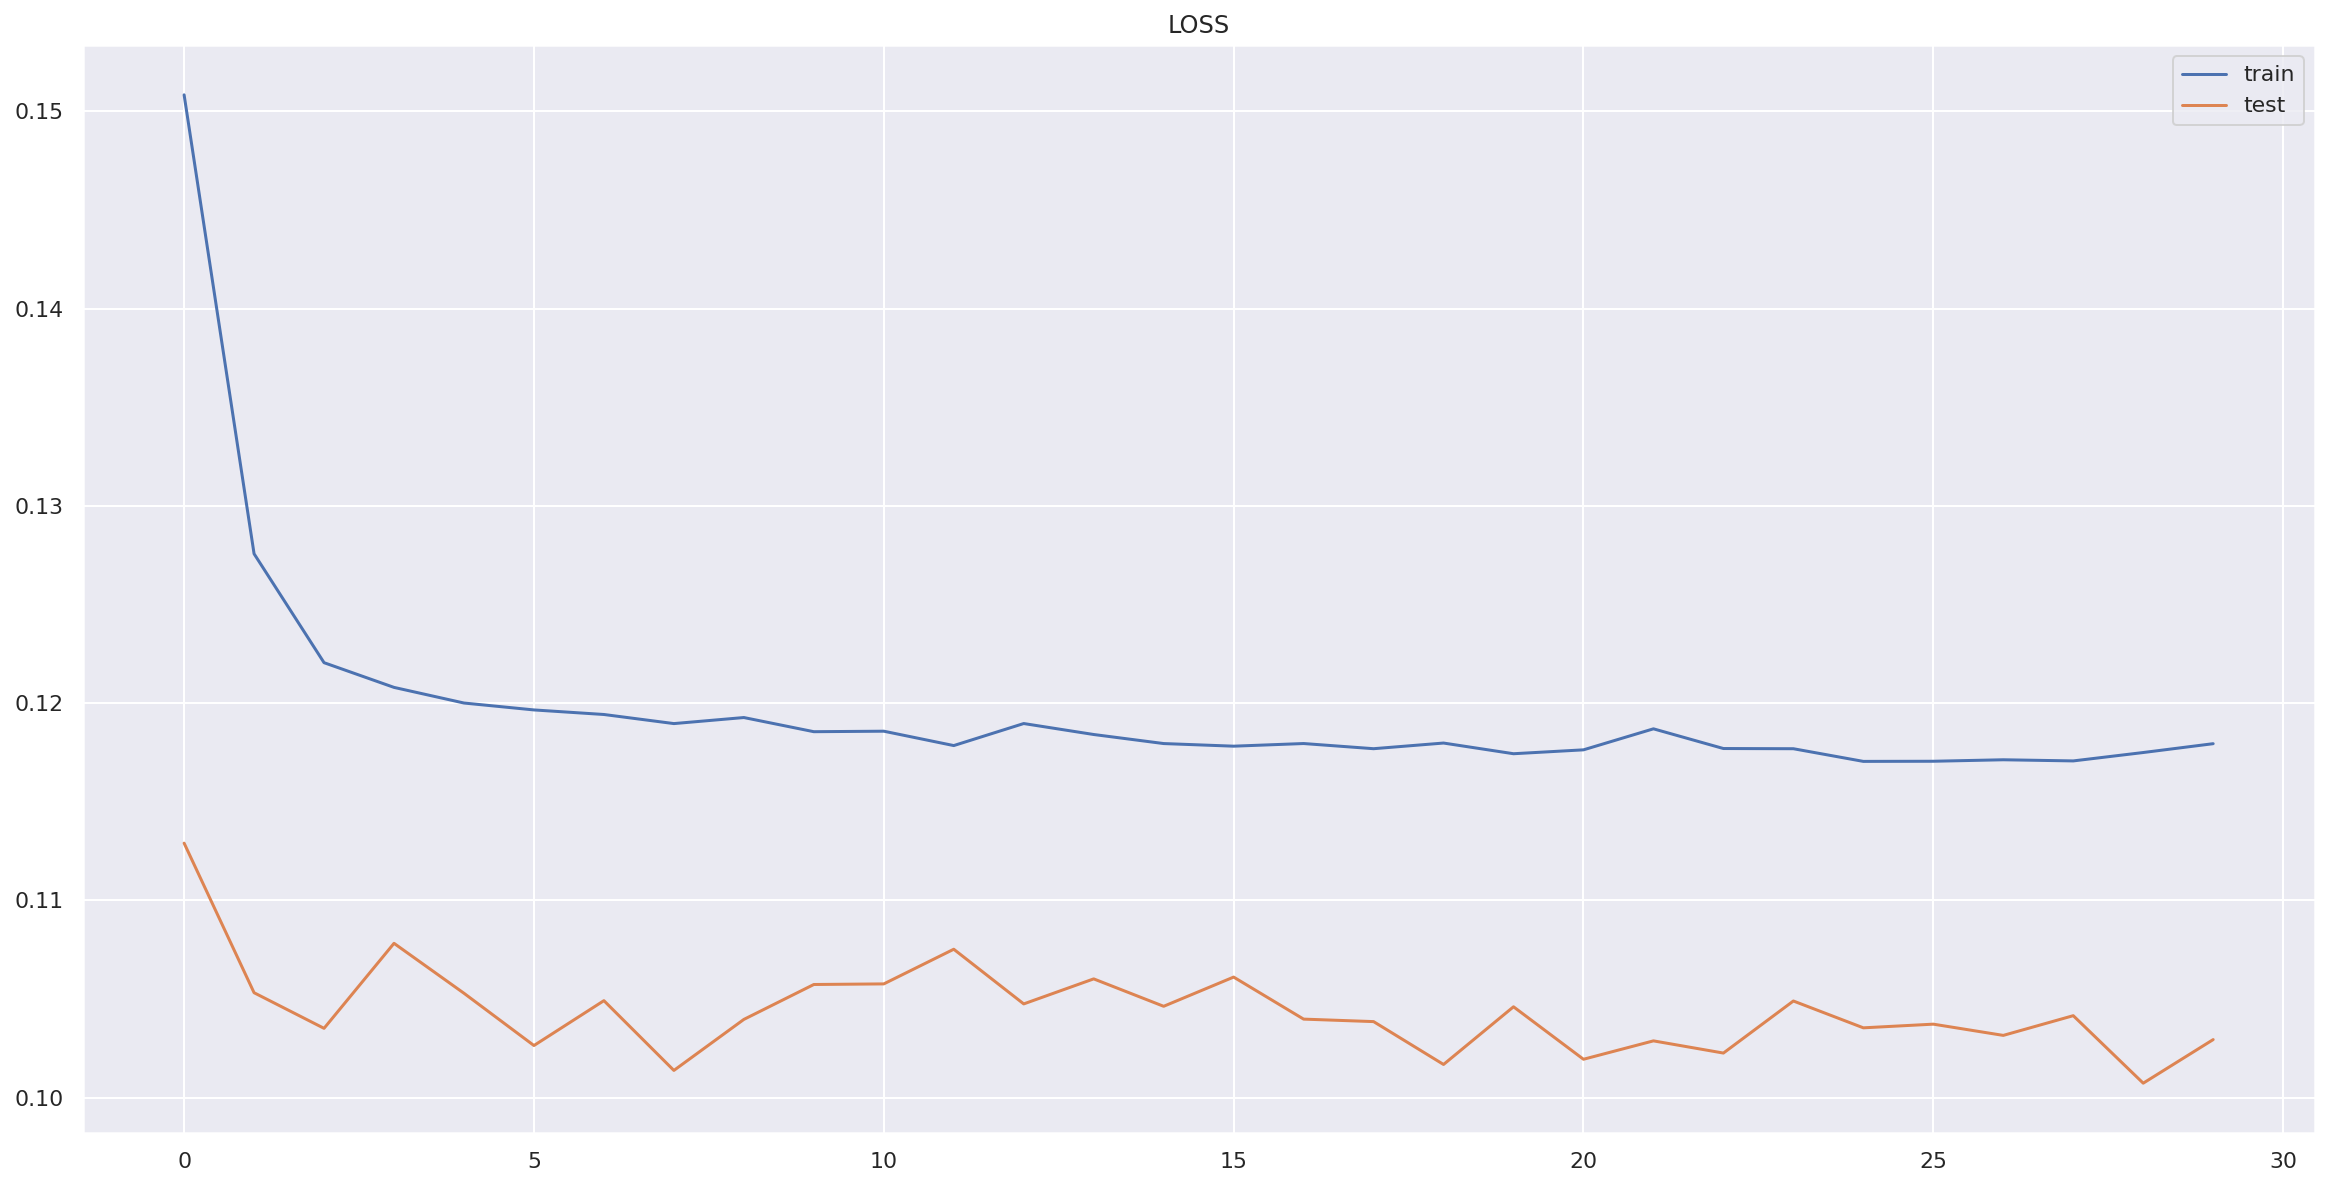

In [ ]:
plt.title('LOSS')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

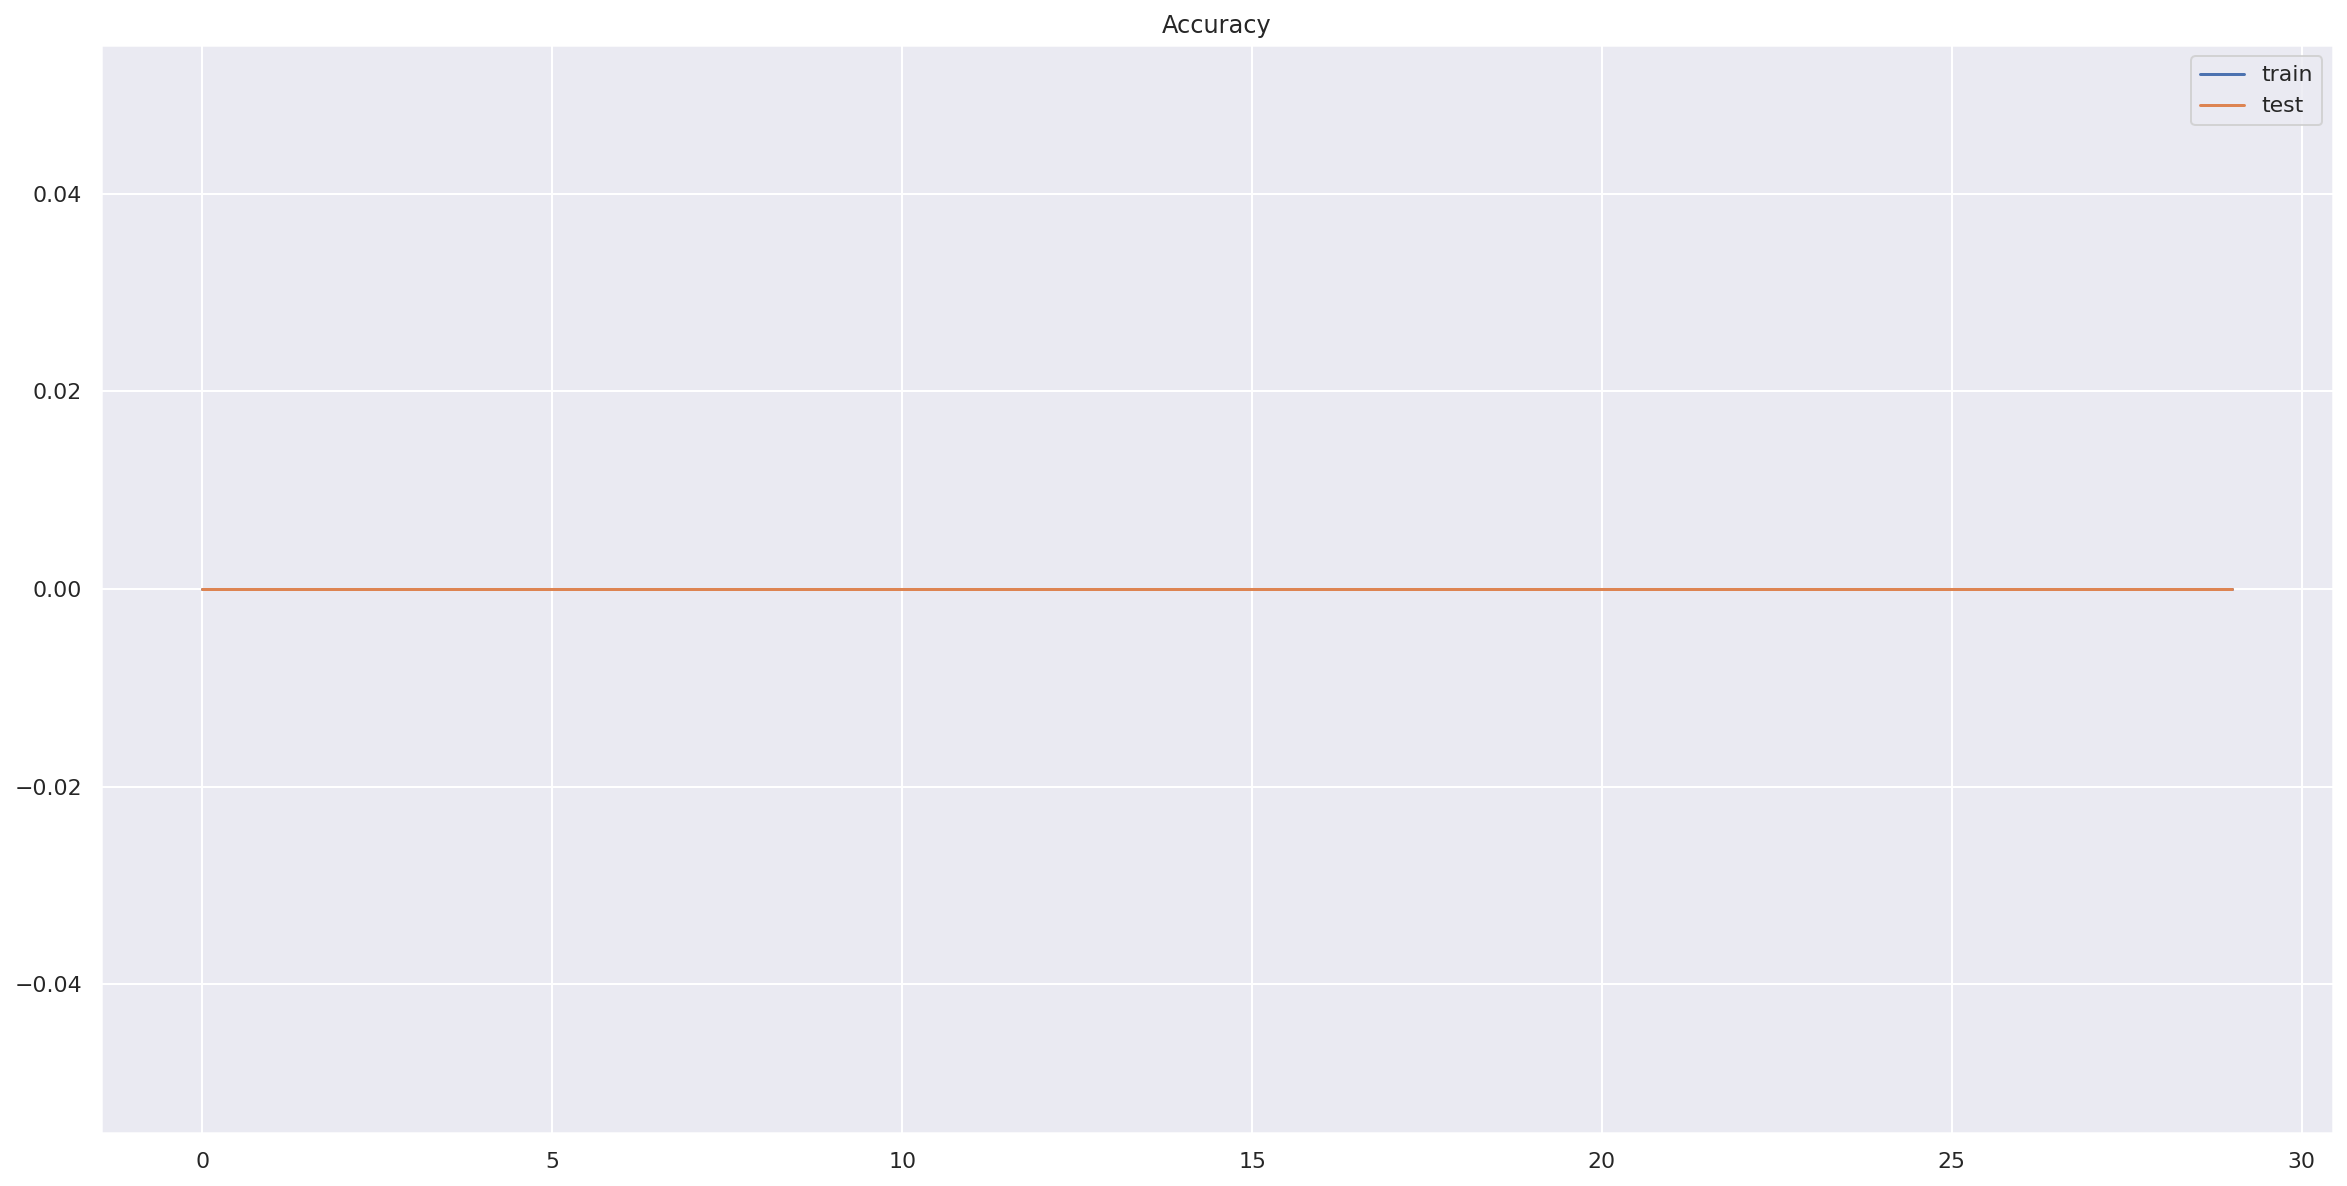

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


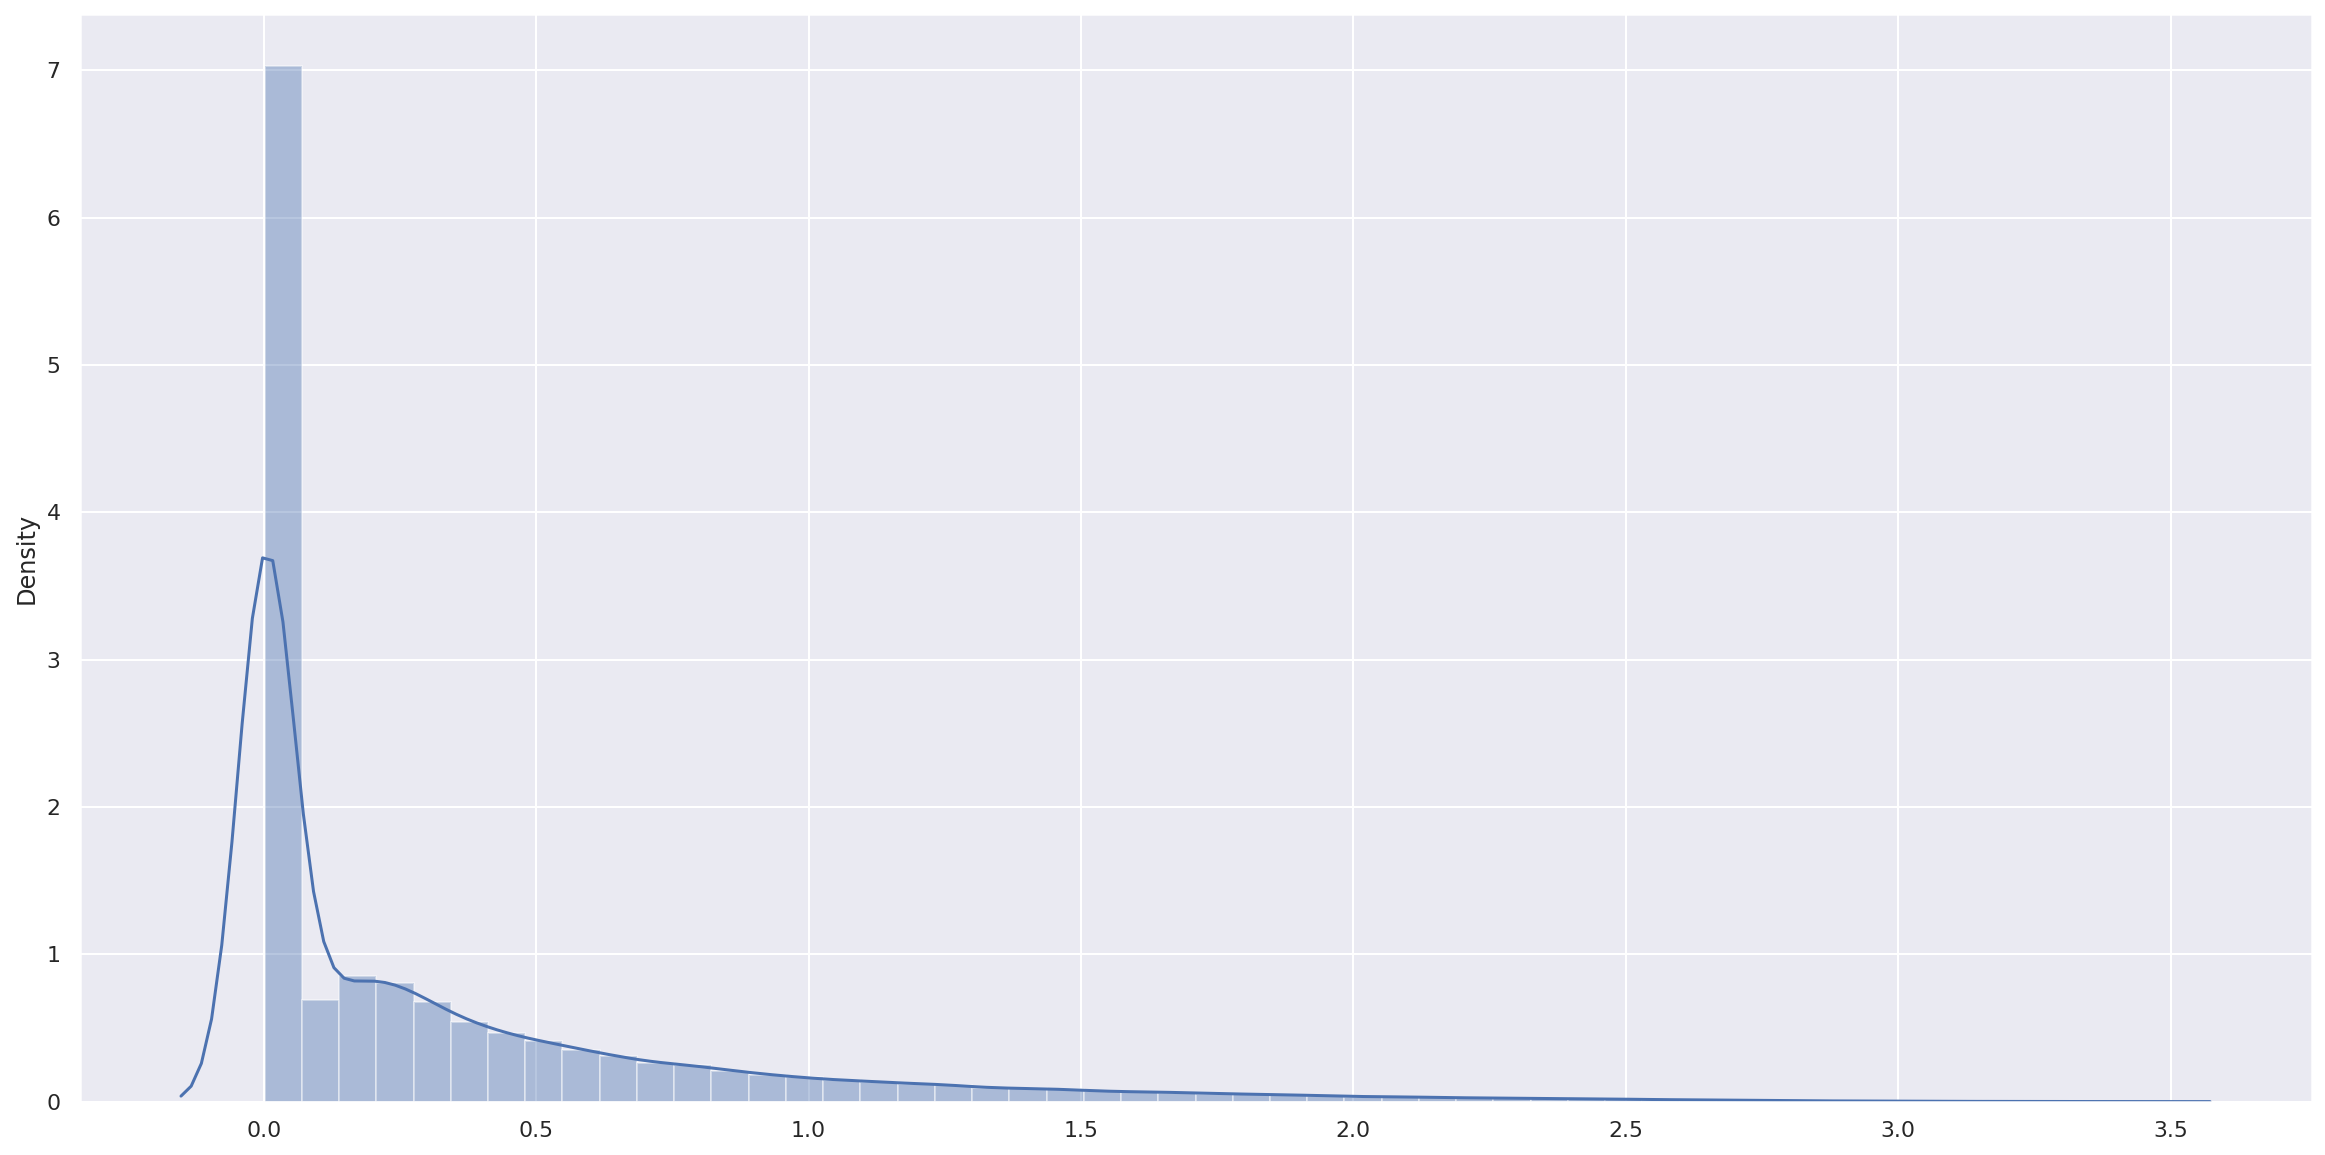

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:
THRESHOLD = 2.5

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['intensitas_cahaya'] = test[TIME_STEPS:].intensitas_cahaya

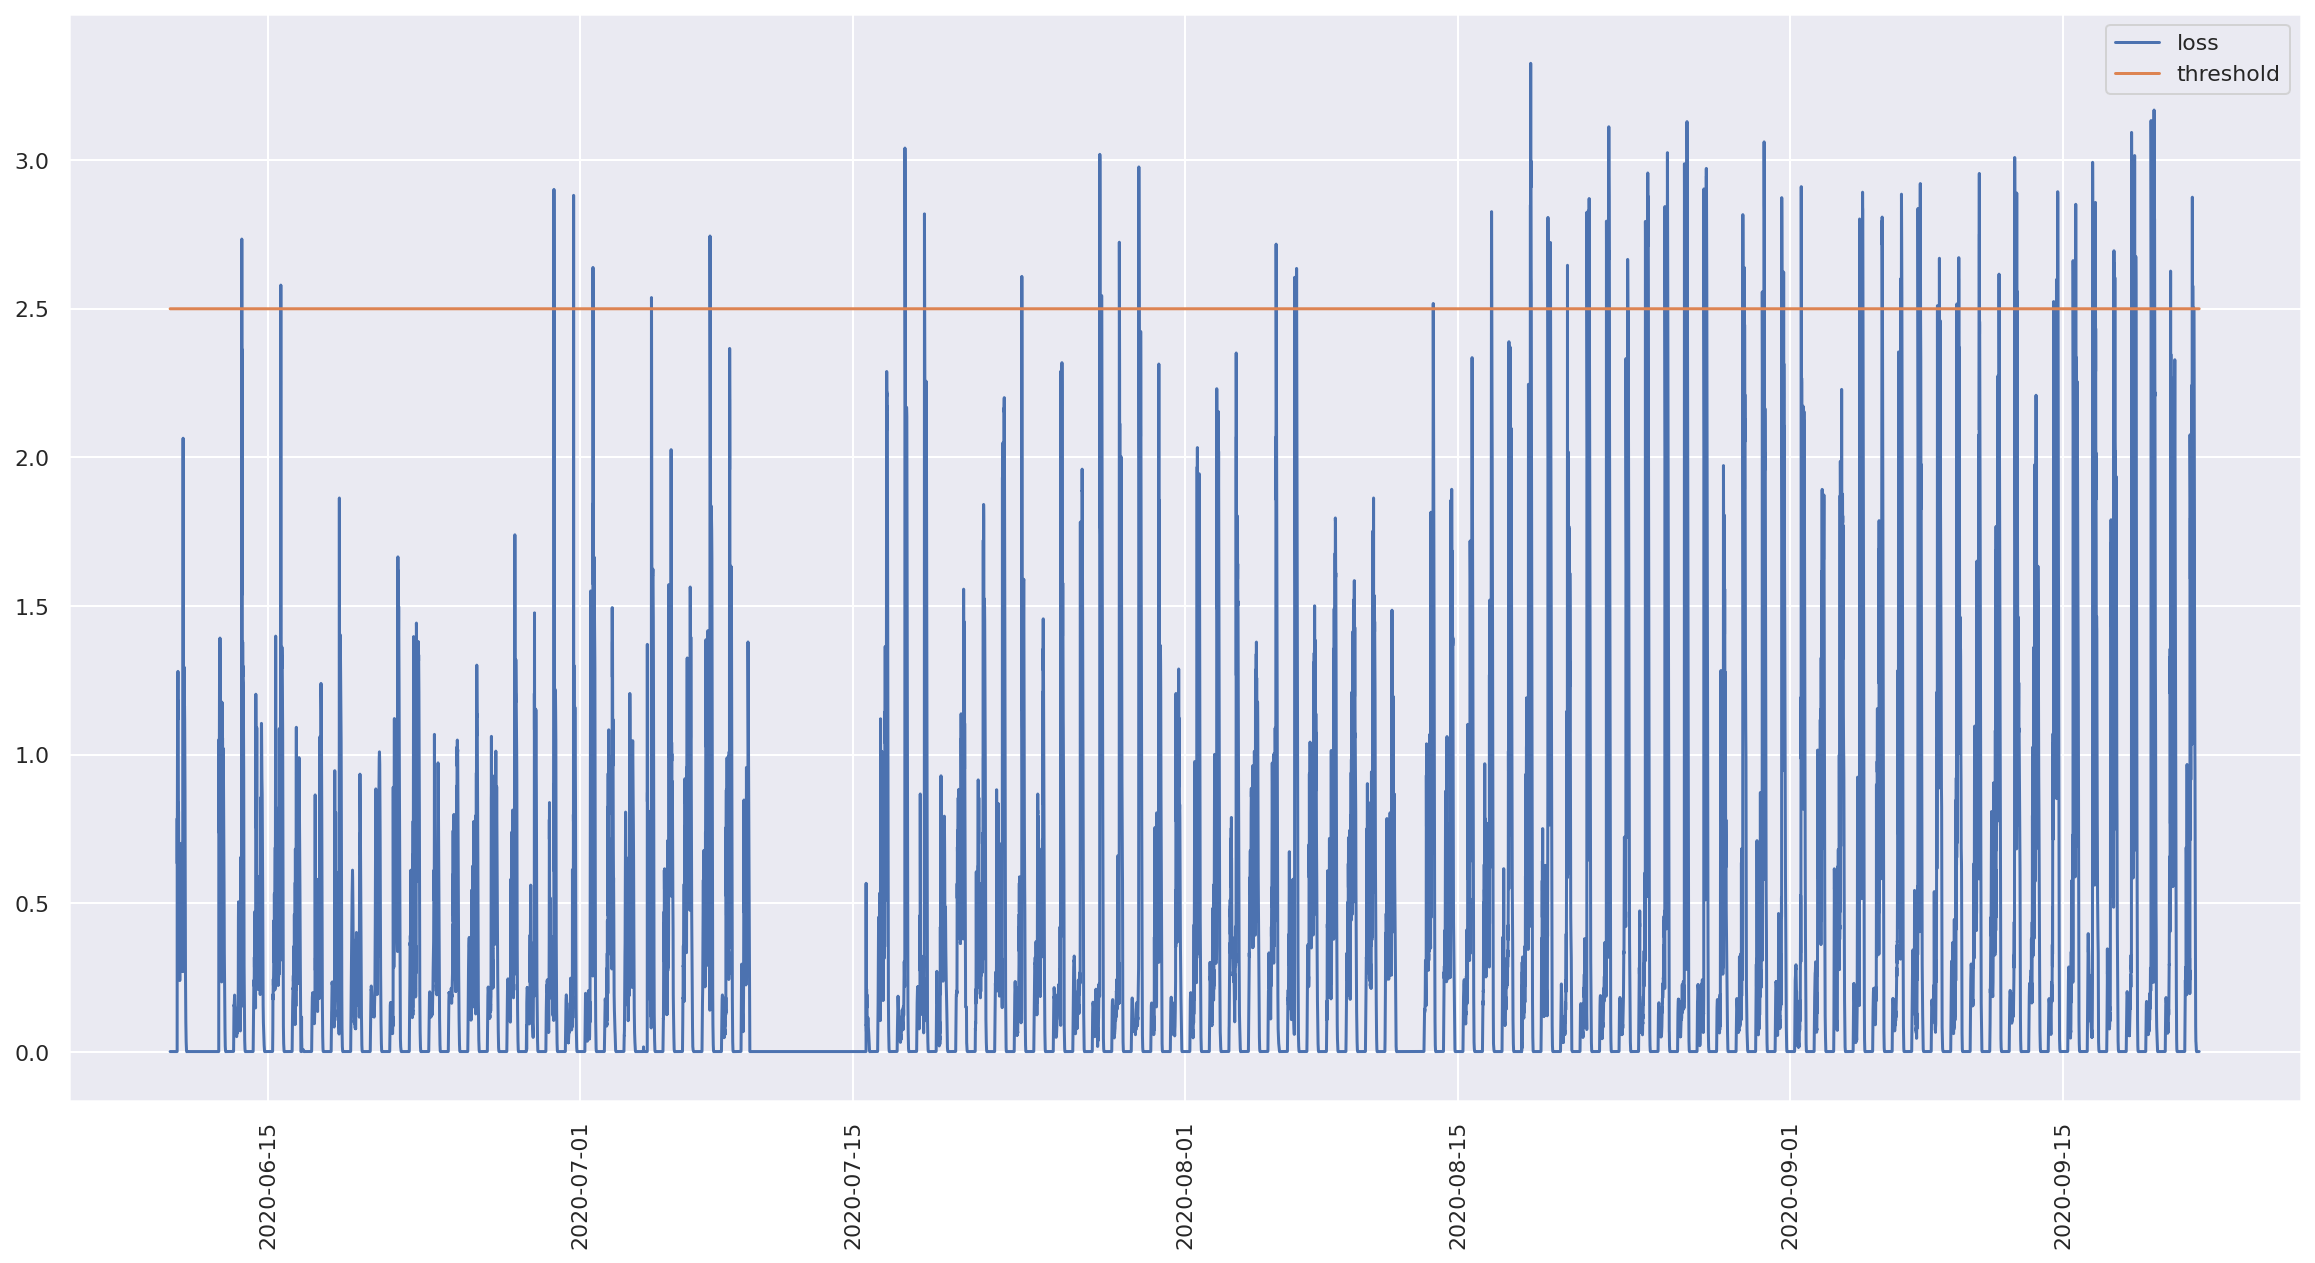

In [ ]:
plt.xticks(rotation='vertical')
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.legend();

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]

anomalies.count()

loss                 294
threshold            294
anomaly              294
intensitas_cahaya    294
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


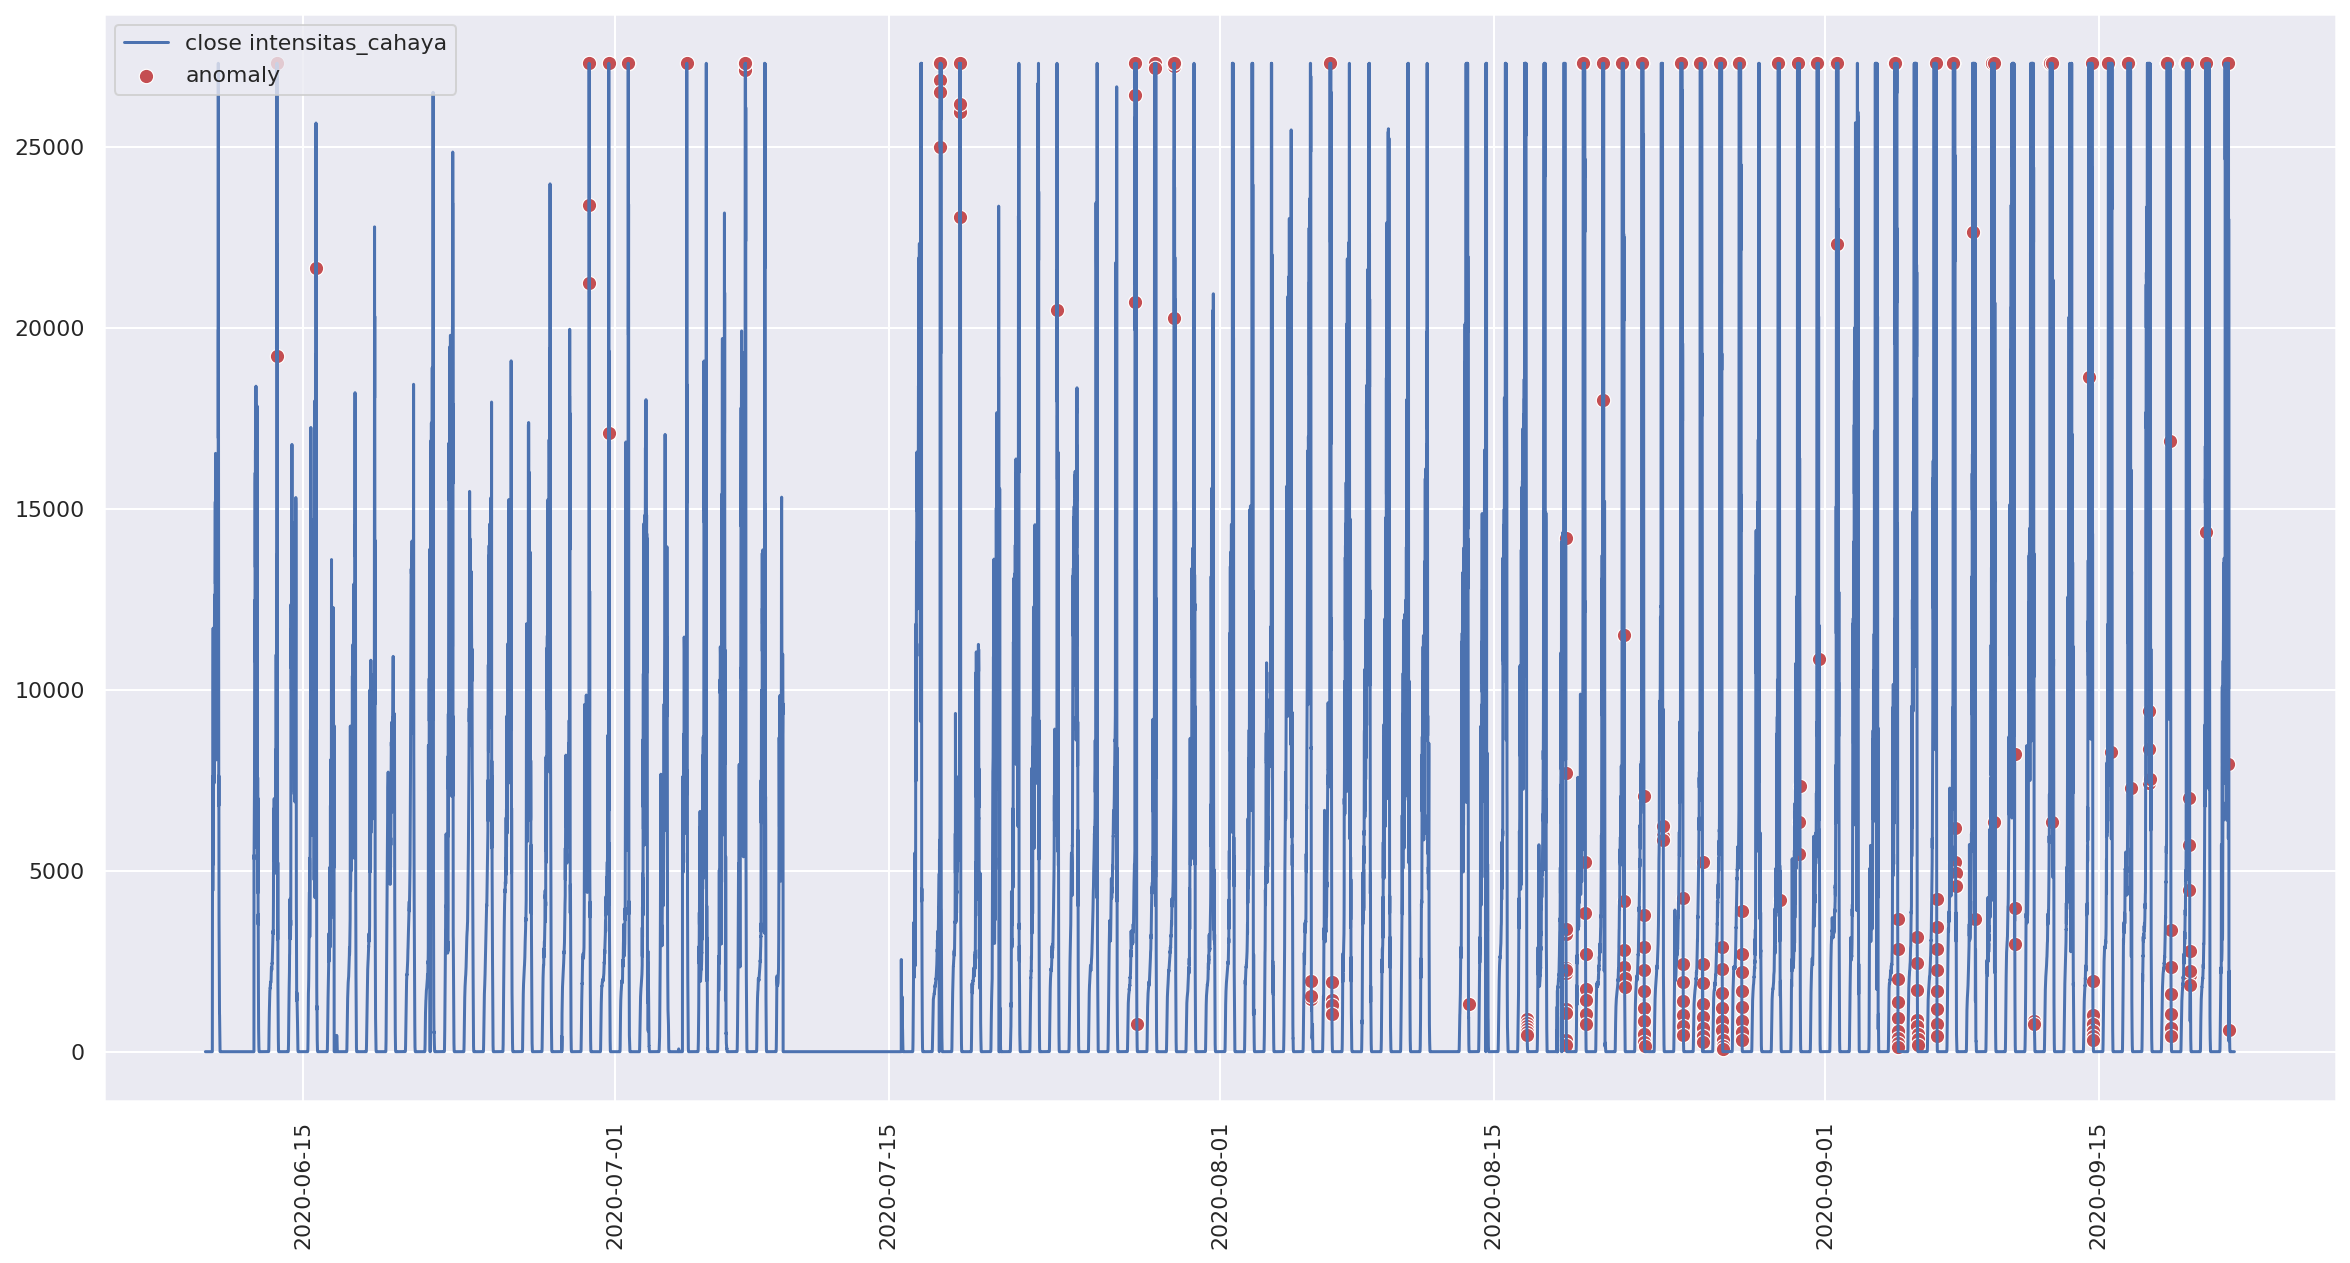

In [ ]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].intensitas_cahaya), 
  label='close intensitas_cahaya'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.intensitas_cahaya),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)

plt.xticks(rotation='vertical')
plt.show()